# Import

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Link / objectives

Energy star : https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results

Problématique de la ville de Seattle
Des relevés minutieux ont été effectués par vos agents en __2015 et en 2016__. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de __l’"ENERGY STAR Score"__ pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.

Votre mission:

- __Réaliser une courte analyse exploratoire.__
- __Tester différents modèles de prédiction afin de répondre au mieux à la problématique.__\


Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes, et erreurs à éviter :

- L’objectif est de te passer des relevés de consommation annuels (attention à la fuite de données), mais rien ne t'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées). 

- Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

- Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.

# Load and clean

## Load Data

In [2]:
df_2015=pd.read_csv('./data/2015-building-energy-benchmarking.csv')
df_2016=pd.read_csv('./data/2016-building-energy-benchmarking.csv')

Le fait d'avoir deux datasets est embetant -> je vais essayer de les concatener sans perdre de la data

## Columns analysis

Analyse des colonnes pour pouvoir concat les deux datasets

In [3]:
len(df_2015.columns)==len(df_2016.columns)

False

In [4]:
col_2015=[]
for column in list(df_2015.columns):
    if column not in (df_2016.columns):
        col_2015.append(column)
print(f"colonnes de 2015 non présente dans 2016 : ")
[print(f'- {i}') for i in col_2015]

colonnes de 2015 non présente dans 2016 : 
- Location
- OtherFuelUse(kBtu)
- GHGEmissions(MetricTonsCO2e)
- GHGEmissionsIntensity(kgCO2e/ft2)
- Comment
- 2010 Census Tracts
- Seattle Police Department Micro Community Policing Plan Areas
- City Council Districts
- SPD Beats
- Zip Codes


[None, None, None, None, None, None, None, None, None, None]

In [5]:
col_2016=[]
for column in list(df_2016.columns):
    if column not in (df_2015.columns):
        col_2016.append(column)
print(f"colonnes de 2015 non présente dans 2016 : ")
[print(f'- {i}') for i in col_2016]

colonnes de 2015 non présente dans 2016 : 
- Address
- City
- State
- ZipCode
- Latitude
- Longitude
- Comments
- TotalGHGEmissions
- GHGEmissionsIntensity


[None, None, None, None, None, None, None, None, None]

<AxesSubplot:xlabel='variable', ylabel='value'>

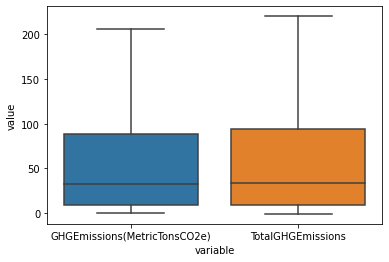

In [6]:
concat_data_1 =pd.concat([df_2015['GHGEmissions(MetricTonsCO2e)'], df_2016['TotalGHGEmissions']], axis=1)
sns.boxplot(x="variable", y="value", data=pd.melt(concat_data_1), showfliers=False)

In [7]:
#seems the same

<AxesSubplot:xlabel='variable', ylabel='value'>

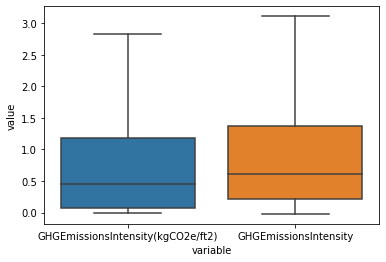

In [8]:
concat_data_2 =pd.concat([df_2015['GHGEmissionsIntensity(kgCO2e/ft2)'], df_2016['GHGEmissionsIntensity']], axis=1)
sns.boxplot(x="variable", y="value", data=pd.melt(concat_data_2), showfliers=False)

In [9]:
#seems the same

In [10]:
df_2015['OtherFuelUse(kBtu)'].value_counts()

0.0          3313
6464408.0       1
178094.0        1
143134.0        1
5596.0          1
229942.0        1
145944.0        1
427938.0        1
1943011.0       1
12551.0         1
547.0           1
15527.0         1
2304567.0       1
2944419.0       1
337952.0        1
8269669.0       1
177849.0        1
182715.0        1
Name: OtherFuelUse(kBtu), dtype: int64

__Todo :__\
__2015__ 
 - Location : extract data [latitude and longitude, adress, ...]
 - comment/comments ->rename
 - GHGEmissions(MetricTonsCO2e) <->TotalGHGEmissions au vue de la data -> rename
 - 'GHGEmissionsIntensity(kgCO2e/ft2)' <-> 'GHGEmissionsIntensity' -> rename
 - OtherFuelUse(kBtu) : peu d'info -> drop
 - Seattle Police Department Micro Community Policing Plan Areas -> semble non relié à notre probleme -> drop
 - City Council Districts : idem -> drop
 - SPD Beats : semble être des problématique police -> drop
 - Zip Codes : je sais ap ce que c'est -> drop


## Data engeeniring for concat

### deal with Location column

In [11]:
# eval - > permet d'eviter d'avoir un format pourri
df_2015['Location'] = [eval(str(item)) for index, item in df_2015.Location.iteritems()]

In [12]:
df_2015['Latitude'] = df_2015['Location'].apply(lambda x : x['latitude'])
df_2015['Longitude'] = df_2015['Location'].apply(lambda x : x['longitude'])
df_2015['City'] = df_2015['Location'].apply(lambda x : eval(x['human_address'])['city'])
df_2015['State'] = df_2015['Location'].apply(lambda x : eval(x['human_address'])['state'])
df_2015['ZipCode'] = df_2015['Location'].apply(lambda x : eval(x['human_address'])['zip'])

### Deal with renaming + drop

In [13]:
df_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)' : 'TotalGHGEmissions',
                       'GHGEmissionsIntensity(kgCO2e/ft2)' : 'GHGEmissionsIntensity',
                       'Comment':'Comments'},
              inplace=True)

In [14]:
df_2015.drop(columns=['OtherFuelUse(kBtu)',
                      'Seattle Police Department Micro Community Policing Plan Areas', 
                      'City Council Districts',
                      'SPD Beats',
                      'Zip Codes',
                      'Location'],
            inplace=True)

### Concat Df 🍾

In [15]:
list(df_2015.columns).sort() == list(df_2016.columns).sort()

True

In [16]:
df = pd.concat([df_2015, df_2016], axis=0)

In [17]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'DefaultData', 'Comments',
       'ComplianceStatus', 'Outlier', '2010 Census Tracts', 

# Data Explo

__Definitions :__
- __GFA__ = Gross Floor Area : is the total property square footage, as measured between the exterior walls of the building(s)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716 entries, 0 to 3375
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    6716 non-null   int64  
 1   DataYear                         6716 non-null   int64  
 2   BuildingType                     6716 non-null   object 
 3   PrimaryPropertyType              6716 non-null   object 
 4   PropertyName                     6716 non-null   object 
 5   TaxParcelIdentificationNumber    6714 non-null   object 
 6   CouncilDistrictCode              6716 non-null   int64  
 7   Neighborhood                     6716 non-null   object 
 8   YearBuilt                        6716 non-null   int64  
 9   NumberofBuildings                6708 non-null   float64
 10  NumberofFloors                   6708 non-null   float64
 11  PropertyGFATotal                 6716 non-null   int64  
 12  PropertyGFAParking  

In [19]:
cat_columns=[]
numeric_columns=[]
for column in list(df.columns):
    if df[column].dtype=='object' :
        cat_columns.append(column)
    else :
        numeric_columns.append(column)

In [20]:
df.select_dtypes('float').columns

Index(['NumberofBuildings', 'NumberofFloors', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', '2010 Census Tracts'],
      dtype='object')

## Numeric columns

### premiere analyse

In [21]:
df[numeric_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716 entries, 0 to 3375
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    6716 non-null   int64  
 1   DataYear                         6716 non-null   int64  
 2   CouncilDistrictCode              6716 non-null   int64  
 3   YearBuilt                        6716 non-null   int64  
 4   NumberofBuildings                6708 non-null   float64
 5   NumberofFloors                   6708 non-null   float64
 6   PropertyGFATotal                 6716 non-null   int64  
 7   PropertyGFAParking               6716 non-null   int64  
 8   PropertyGFABuilding(s)           6716 non-null   int64  
 9   LargestPropertyUseTypeGFA        6560 non-null   float64
 10  SecondLargestPropertyUseTypeGFA  3238 non-null   float64
 11  ThirdLargestPropertyUseTypeGFA   1156 non-null   float64
 12  ENERGYSTARScore     

OSEBuildingID


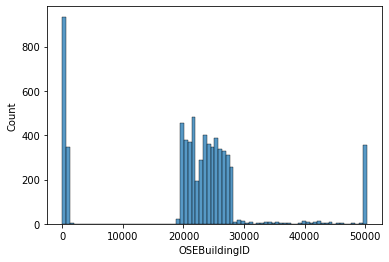

DataYear
2016    3376
2015    3340
Name: DataYear, dtype: int64


CouncilDistrictCode
7    2074
3    1180
2    1016
4     711
5     681
1     562
6     492
Name: CouncilDistrictCode, dtype: int64


YearBuilt


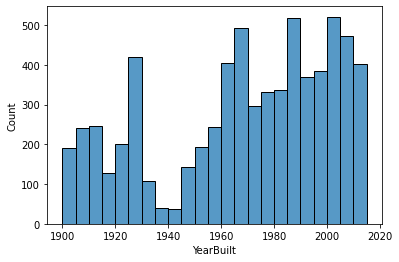

NumberofBuildings


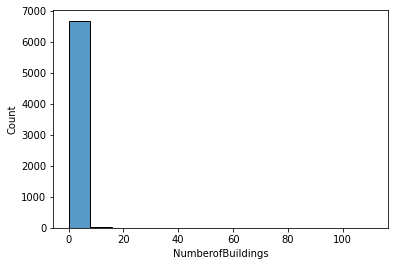

NumberofFloors


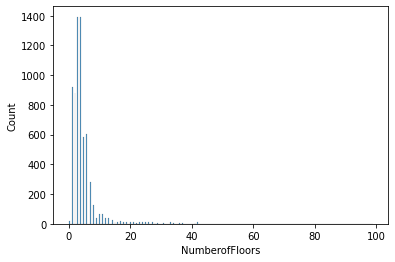

PropertyGFATotal


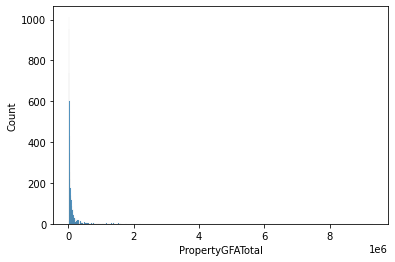

PropertyGFAParking


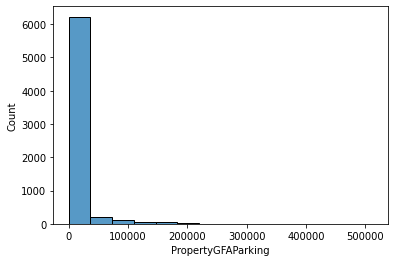

PropertyGFABuilding(s)


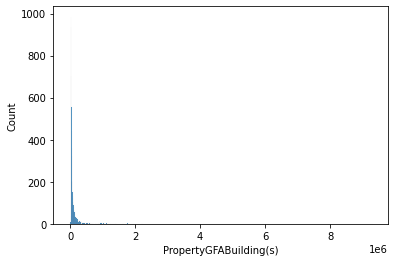

LargestPropertyUseTypeGFA


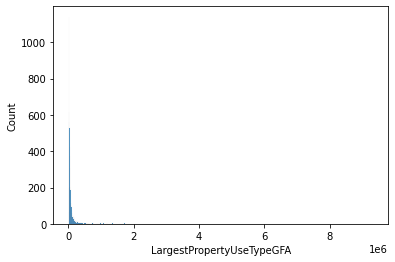

SecondLargestPropertyUseTypeGFA


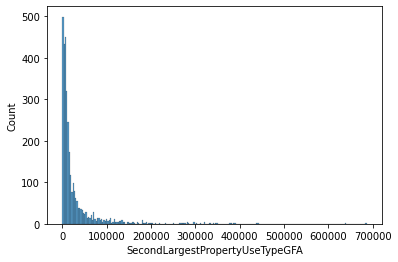

ThirdLargestPropertyUseTypeGFA


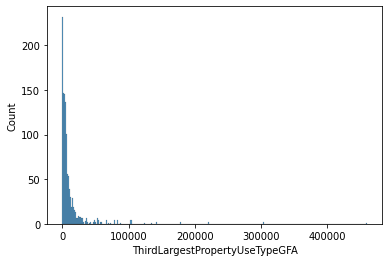

ENERGYSTARScore


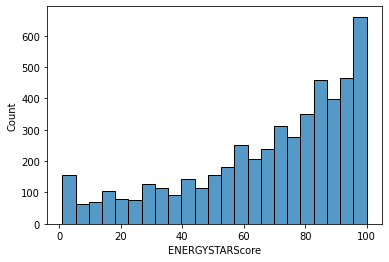

SiteEUI(kBtu/sf)


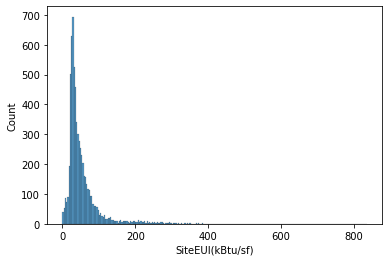

SiteEUIWN(kBtu/sf)


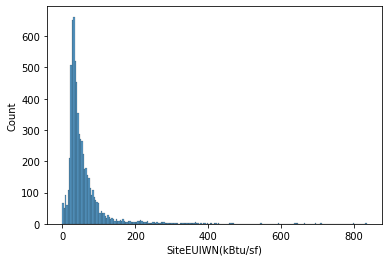

SourceEUI(kBtu/sf)


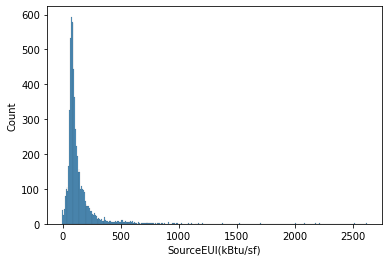

SourceEUIWN(kBtu/sf)


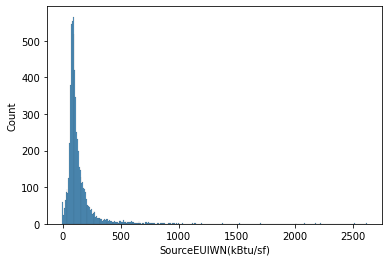

SiteEnergyUse(kBtu)


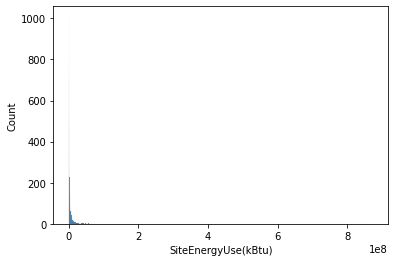

SiteEnergyUseWN(kBtu)


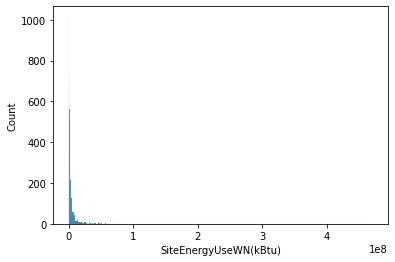

SteamUse(kBtu)


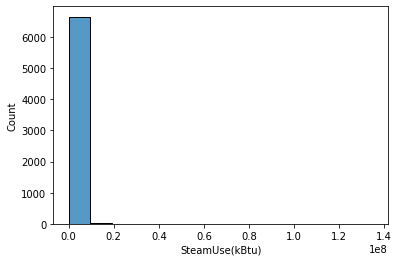

Electricity(kWh)


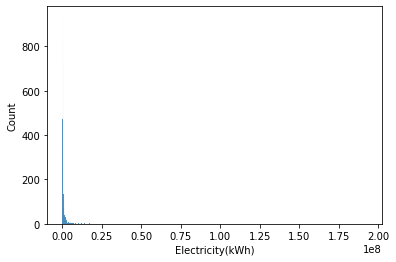

Electricity(kBtu)


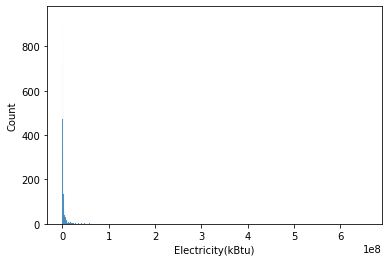

NaturalGas(therms)


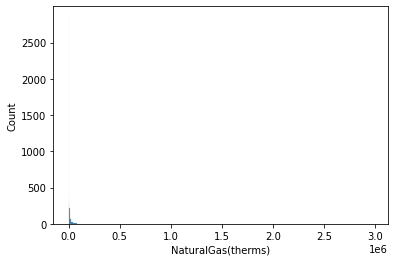

NaturalGas(kBtu)


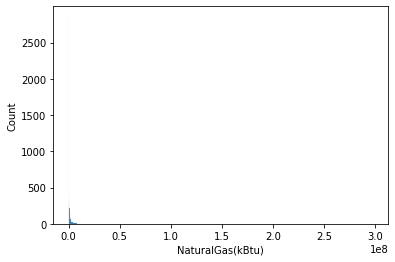

TotalGHGEmissions


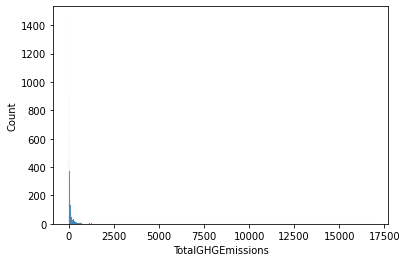

GHGEmissionsIntensity


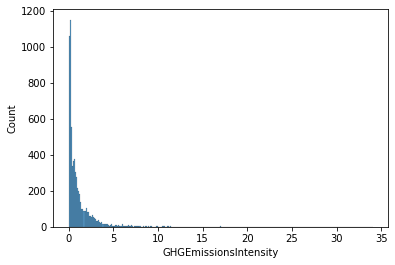

2010 Census Tracts


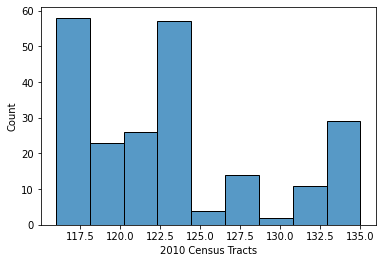

In [22]:
for column in numeric_columns:
    if len(df[column].value_counts())<10:
        print(column)
        print(df[column].value_counts())
        print('\n')
    else :
        print(column)
        sns.histplot(df[column])
        plt.show()

In [23]:
numeric_columns

['OSEBuildingID',
 'DataYear',
 'CouncilDistrictCode',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 '2010 Census Tracts']

<AxesSubplot:>

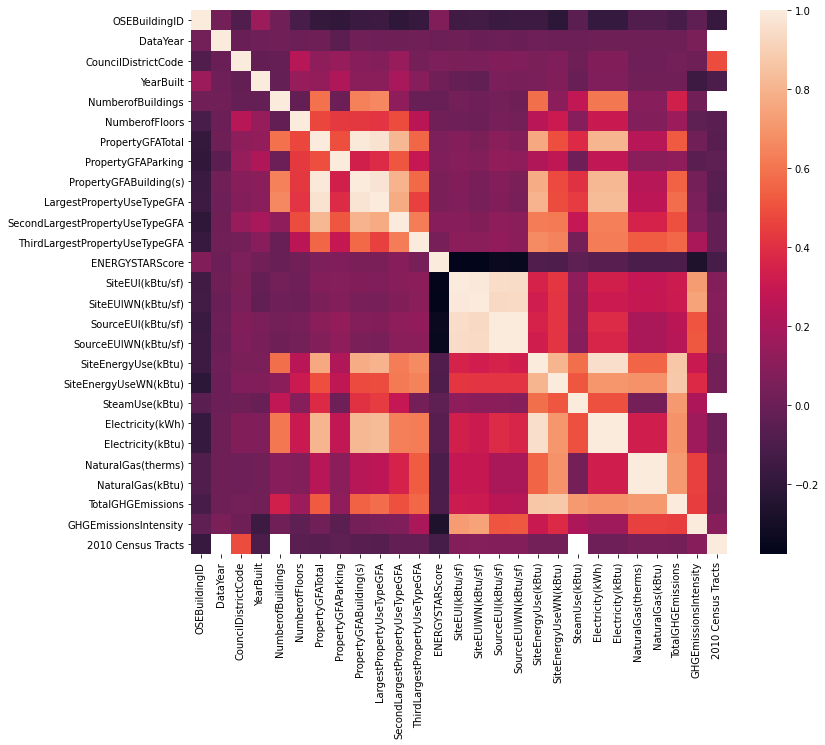

In [24]:
plt.figure(figsize=(12,10))
sns.heatmap(df[numeric_columns].corr())

In [25]:
corr = df.corr()
corr.style.background_gradient(cmap='Greens').set_precision(3)

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_34453/2921387194.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='Greens').set_precision(3)


colonne contenant WN:
- "Weather Normalized (WN) Site Energy Use Intensity (EUI) is a property's WN Site Energy divided by its gross floor area (in square feet). WN Site Energy is the Site Energy Use the property would have consumed during 30-year average weather conditions. WN Site EUI is measured in measured in thousands of British thermal units (kBtu) per square foot." -> semble peut pertinant à premiere vue 


In [26]:
numeric_to_drop=[
    'SiteEnergyUseWN(kBtu)',
    'SiteEUIWN(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)',
    'Electricity(kWh)', #je garde en kwh
    'NaturalGas(therms)',
    '2010 Census Tracts',#trop d'outliers
    'LargestPropertyUseTypeGFA',# a voir
    'SecondLargestPropertyUseTypeGFA',#a voir
    'ThirdLargestPropertyUseTypeGFA',#a voir
    'SiteEUI(kBtu/sf)', # pour la problématique je suprime ces données dépendantes de la surface
    'SourceEUI(kBtu/sf)',# pour la problématique je suprime ces données dépendantes de la surface
    'GHGEmissionsIntensity',# pour la problématique je suprime ces données dépendantes de la surface
    'SteamUse(kBtu)', #à éviter car provient de relevé
    'Electricity(kBtu)', #à éviter car provient de relevé
    'NaturalGas(kBtu)', #à éviter car provient de relevé
    'PropertyGFATotal' #du à la corrélation avec PropertyGFPrking /Building(s)
    ]

In [27]:
df.drop(columns=numeric_to_drop, inplace=True)

In [28]:
numeric_columns = [i for i in numeric_columns if i not in numeric_to_drop]

### Check outliers

In [29]:
df[numeric_columns].describe()

OSEBuildingID    DataYear  CouncilDistrictCode    YearBuilt  \
count    6716.000000  6716.00000          6716.000000  6716.000000   
mean    20867.420488  2015.50268             4.445057  1968.101549   
std     11878.968174     0.50003             2.123749    33.020391   
min         1.000000  2015.00000             1.000000  1900.000000   
25%     19934.000000  2015.00000             3.000000  1948.000000   
50%     23064.000000  2016.00000             4.000000  1974.000000   
75%     25868.250000  2016.00000             7.000000  1996.000000   
max     50226.000000  2016.00000             7.000000  2015.000000   

       NumberofBuildings  NumberofFloors  PropertyGFAParking  \
count        6708.000000     6708.000000         6716.000000   
mean            1.071407        4.695736         9519.597975   
std             1.593505        5.476218        33868.050881   
min             0.000000        0.000000           -3.000000   
25%             1.000000        2.000000            0.000000   
50%             1.000000        4.000000            0.000000   
75%             1.000000        5.000000            0.000000   
max           111.000000       99.000000       512608.000000   

       PropertyGFABuilding(s)  ENERGYSTARScore  SiteEnergyUse(kBtu)  \
count            6.716000e+03      5093.000000         6.701000e+03   
mean             8.329450e+04        67.906342         5.194673e+06   
std              1.733470e+05        27.012124         1.813648e+07   
min             -5.055000e+04         1.000000         0.000000e+00   
25%              2.727300e+04        52.000000         9.200689e+05   
50%              4.218500e+04        75.000000         1.791071e+06   
75%              8.112000e+04        90.000000         4.135280e+06   
max              9.320156e+06       100.000000         8.739237e+08   

       TotalGHGEmissions  
count        6697.000000  
mean          114.935638  
std           478.876573  
min            -0.800000  
25%             9.450000  
50%            33.180000  
75%            91.530000  
max         16870.980000

__Pour remplir les données manquantes des étages/nombres de batiments :__
- remplir par la vaeur associé à l'id du batiment de l'autre année
- par défaut : par 0
- puis remplacer 0 par 1.. *-> à voir implémentation méthode par la moyenne des batiements de la même catégorie ?*

In [30]:
#NumberofBuildings
df['NumberofBuildings'] = df['NumberofBuildings'].fillna(df.groupby('OSEBuildingID')['NumberofBuildings'].transform('max'))
df['NumberofBuildings']=df['NumberofBuildings'].fillna(0)
df['NumberofBuildings'] = df['NumberofBuildings'].replace(0.0, 1.0)
df['NumberofBuildings'].unique()

array([  1.,   7.,  11.,  16.,   4.,   3.,  39.,   2.,  10.,   6.,  27.,
        14.,   9.,   5.,   8.,  23., 111.])

In [31]:
#NumberofFloors cant be 0 floors + deal with outliers
df['NumberofFloors'] = df['NumberofFloors'].fillna(df.groupby('OSEBuildingID')['NumberofFloors'].transform('max'))
df['NumberofFloors'] = df['NumberofFloors'].replace(0.0, 1.0)

In [32]:
df['NumberofFloors'].value_counts()

3.0     1393
4.0     1392
1.0      945
2.0      884
6.0      605
5.0      584
7.0      281
8.0      124
11.0      64
10.0      63
13.0      41
12.0      39
9.0       36
14.0      25
17.0      18
15.0      15
16.0      14
18.0      14
24.0      14
23.0      13
19.0      12
26.0      12
42.0      12
33.0      12
27.0      10
25.0      10
21.0      10
20.0       9
22.0       8
29.0       6
41.0       5
31.0       4
34.0       4
37.0       4
36.0       4
28.0       4
38.0       2
39.0       2
32.0       2
99.0       2
76.0       2
55.0       2
56.0       2
30.0       2
46.0       2
63.0       2
49.0       2
47.0       2
40.0       2
Name: NumberofFloors, dtype: int64

In [33]:
#PropertyGFAParking
df['PropertyGFAParking']=df['PropertyGFAParking'].replace(-3.0, 0.0)

In [34]:
# PropertyGFABuilding(s)
property_gfa_building_neg = list(df[(df['PropertyGFABuilding(s)']<0)]['OSEBuildingID'])
for id_ in property_gfa_building_neg: 
    to_replace = df[(df['OSEBuildingID']==id_)&(df['PropertyGFABuilding(s)']<0)]['PropertyGFABuilding(s)'].item()
    value = df[(df['OSEBuildingID']==id_)&(df['PropertyGFABuilding(s)']>0)]['PropertyGFABuilding(s)'].item()
    df['PropertyGFABuilding(s)']=df['PropertyGFABuilding(s)'].replace(to_replace, value)

In [35]:
df['PropertyGFABuilding(s)'].min()

3636

## Cat Columns

In [36]:
for column in cat_columns:
    if len(df[column].value_counts())<10:
        print(column)
        print(df[column].value_counts())
        print(f"{len(df[df[column].isna()])} valeurs manquantes'")
        print('\n')
    else :
        print(f'la colonne {column} contient {len(df[column].value_counts())} valeurs différentes et {len(df[df[column].isna()])} valeurs manquantes')
        print('\n')
    

BuildingType
NonResidential          2921
Multifamily LR (1-4)    2047
Multifamily MR (5-9)    1134
Multifamily HR (10+)     217
SPS-District K-12        197
Nonresidential COS       153
Campus                    46
Nonresidential WA          1
Name: BuildingType, dtype: int64
0 valeurs manquantes'


la colonne PrimaryPropertyType contient 32 valeurs différentes et 0 valeurs manquantes


la colonne PropertyName contient 6527 valeurs différentes et 0 valeurs manquantes


la colonne TaxParcelIdentificationNumber contient 3729 valeurs différentes et 2 valeurs manquantes


la colonne Neighborhood contient 19 valeurs différentes et 0 valeurs manquantes


la colonne ListOfAllPropertyUseTypes contient 488 valeurs différentes et 136 valeurs manquantes


la colonne LargestPropertyUseType contient 57 valeurs différentes et 156 valeurs manquantes


la colonne SecondLargestPropertyUseType contient 50 valeurs différentes et 3478 valeurs manquantes


la colonne ThirdLargestPropertyUseType contient 4

In [37]:
#BuildingType
df['BuildingType']=df['BuildingType'].replace('Nonresidential COS', 'NonResidential')
df['BuildingType']=df['BuildingType'].replace('Nonresidential WA', 'NonResidential')
df['BuildingType'].value_counts()

NonResidential          3075
Multifamily LR (1-4)    2047
Multifamily MR (5-9)    1134
Multifamily HR (10+)     217
SPS-District K-12        197
Campus                    46
Name: BuildingType, dtype: int64

<AxesSubplot:xlabel='count', ylabel='PrimaryPropertyType'>

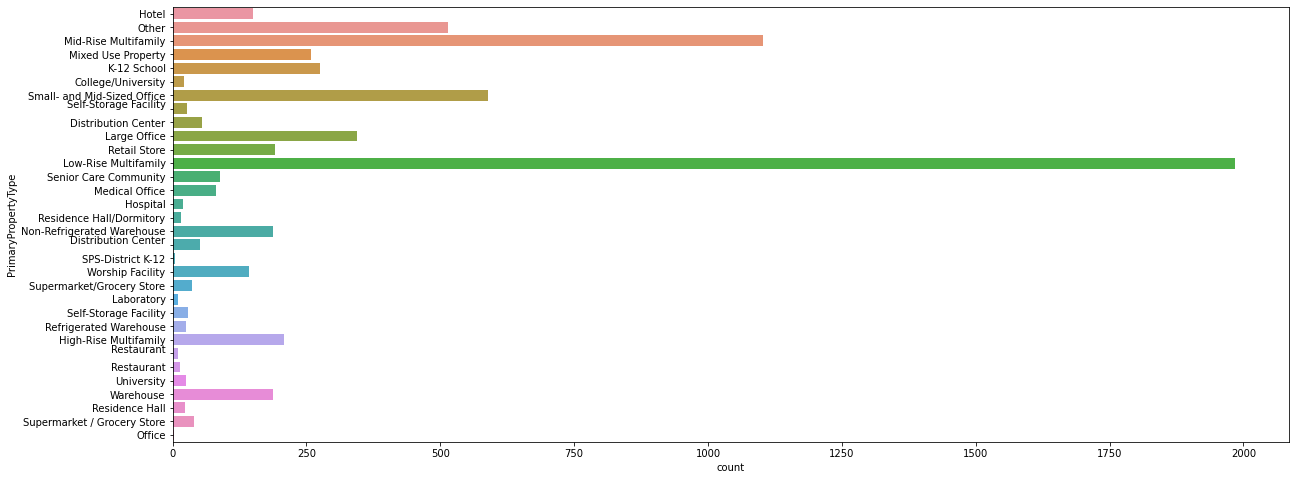

In [38]:
#PrimaryPropertyType
plt.figure(figsize=(20,8))
sns.countplot(y=df['PrimaryPropertyType'], orient='v')

In [39]:
test = df[['PrimaryPropertyType', 'OSEBuildingID']]
dfg=test.groupby(['OSEBuildingID']).agg(set).reset_index()
dfg['taille'] = dfg['PrimaryPropertyType'].apply(lambda x : len(x))
list(dfg[dfg['taille']>1]['PrimaryPropertyType'])

[{'College/University', 'University'},
 {'Self-Storage Facility', 'Self-Storage Facility\n'},
 {'Distribution Center', 'Warehouse'},
 {'Self-Storage Facility', 'Self-Storage Facility\n'},
 {'Other', 'Retail Store'},
 {'College/University', 'University'},
 {'College/University', 'University'},
 {'College/University', 'University'},
 {'Residence Hall', 'Residence Hall/Dormitory'},
 {'Self-Storage Facility', 'Self-Storage Facility\n'},
 {'College/University', 'University'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Self-Storage Facility', 'Self-Storage Facility\n'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Distribution Center', 'Distribution Center\n'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'K-12 School', 'SPS-District K-12'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Residence Hall', 'Residence Hall/Dormitory'},
 {'Mixed Use Property', 'Other'},
 {'Non-Refrigerated 

<AxesSubplot:xlabel='count', ylabel='PrimaryPropertyType'>

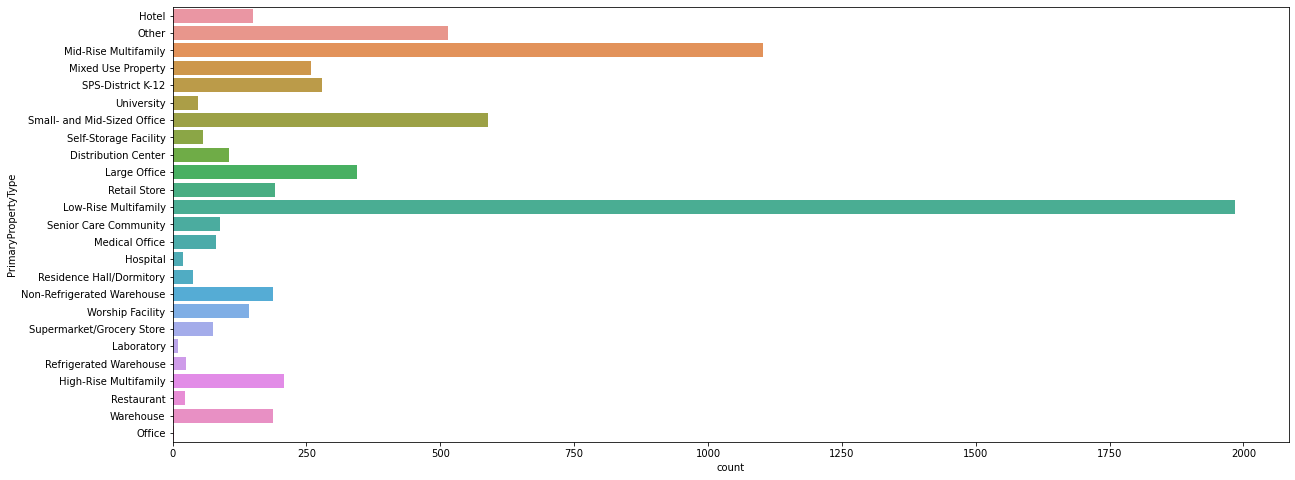

In [40]:
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('College/University', 'University')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Self-Storage Facility\n', 'Self-Storage Facility')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Distribution Center\n', 'Distribution Center')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Residence Hall', 'Residence Hall/Dormitory')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('K-12 School', 'SPS-District K-12')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Supermarket / Grocery Store', \
                                                            'Supermarket/Grocery Store')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Restaurant\n', 'Restaurant')
plt.figure(figsize=(20,8))
sns.countplot(y=df['PrimaryPropertyType'], orient='v')

In [41]:
df_test = df[~(df['PrimaryPropertyType']=='Low-Rise Multifamily')&~(df['PrimaryPropertyType']=='Mid-Rise Multifamily')]
df_test = df_test[df_test['SiteEnergyUse(kBtu)']<50000000]
df_test=df_test.sort_values(by='PrimaryPropertyType')

<AxesSubplot:ylabel='SiteEnergyUse(kBtu)'>

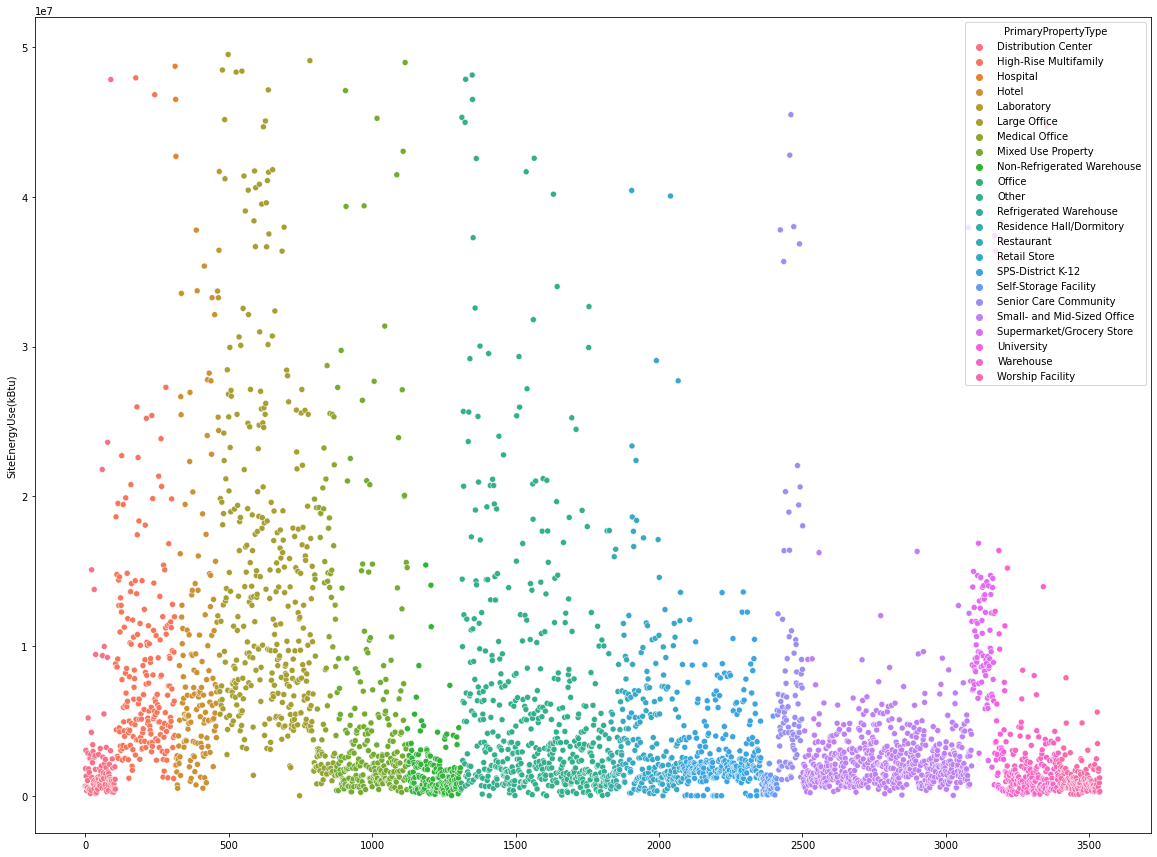

In [42]:
plt.figure(figsize=(20,15))
sns.scatterplot(y=df_test['SiteEnergyUse(kBtu)'], x=[i for i in range(len(df_test))], hue=df_test['PrimaryPropertyType'])


In [43]:
df[['PrimaryPropertyType', 'SiteEnergyUse(kBtu)']].groupby('PrimaryPropertyType').mean()

SiteEnergyUse(kBtu)
PrimaryPropertyType                             
Distribution Center                 2.801173e+06
High-Rise Multifamily               8.853671e+06
Hospital                            1.360147e+08
Hotel                               1.259181e+07
Laboratory                          2.620197e+07
Large Office                        1.748065e+07
Low-Rise Multifamily                1.329059e+06
Medical Office                      1.188233e+07
Mid-Rise Multifamily                2.777192e+06
Mixed Use Property                  9.086191e+06
Non-Refrigerated Warehouse          1.726504e+06
Office                              5.800745e+05
Other                               9.771510e+06
Refrigerated Warehouse              3.522608e+06
Residence Hall/Dormitory            3.448770e+06
Restaurant                          5.181074e+06
Retail Store                        4.864268e+06
SPS-District K-12                   2.905481e+06
Self-Storage Facility               9.125161e+05
Senior Care Community               8.834183e+06
Small- and Mid-Sized Office         2.603963e+06
Supermarket/Grocery Store           9.983782e+06
University                          3.585670e+07
Warehouse                           1.961577e+06
Worship Facility                    1.171687e+06

In [44]:
#Neighborhood
df['Neighborhood']=df['Neighborhood'].str.upper()
df['Neighborhood']=df['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')
print(df['Neighborhood'].value_counts())

DOWNTOWN                 1151
EAST                      897
MAGNOLIA / QUEEN ANNE     843
GREATER DUWAMISH          744
NORTHEAST                 539
LAKE UNION                500
NORTHWEST                 447
NORTH                     375
SOUTHWEST                 331
CENTRAL                   265
BALLARD                   263
SOUTHEAST                 191
DELRIDGE                  170
Name: Neighborhood, dtype: int64


In [45]:
#ListOfAllPropertyUseTypes
df['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property',
       'SPS-District K-12', 'University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility', 'Distribution Center', 'Large Office',
       'Retail Store', 'Low-Rise Multifamily', 'Senior Care Community',
       'Medical Office', 'Hospital', 'Residence Hall/Dormitory',
       'Non-Refrigerated Warehouse', 'Worship Facility',
       'Supermarket/Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'High-Rise Multifamily', 'Restaurant',
       'Warehouse', 'Office'], dtype=object)

In [46]:
df['LargestPropertyUseType'].unique()

array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       'Multifamily Housing', nan, 'Library',
       'Fitness Center/Health Club/Gym', 'Social/Meeting Hall',
       'Courthouse', 'Other', 'K-12 School', 'College/University',
       'Automobile Dealership', 'Office', 'Self-Storage Facility',
       'Retail Store', 'Senior Care Community', 'Medical Office',
       'Hospital (General Medical & Surgical)', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital', 'Financial Office',
       'Non-Refrigerated Warehouse', 'Distribution Center', 'Parking',
       'Worship Facility', 'Laboratory', 'Supermarket/Grocery Store',
       'Convention Center', 'Urgent Care/Clinic/Other Outpatient',
       'Other - Services', 'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Other - Recreation', 'Lifestyle Center',
       'Other - Public S

In [47]:
#latitude-longitude
df['Latitude'] = df['Latitude'].astype('float')
df['Longitude'] = df['Longitude'].astype('float')

In [48]:
to_drop=[
    'TaxParcelIdentificationNumber', #pas d'interet
    'PropertyName', # pas d'interet
    'ListOfAllPropertyUseTypes', # pas d'interet
    'LargestPropertyUseType',# a voir mais beaucoup de taf
    'SecondLargestPropertyUseType',# a voir mais beaucoup de taf
    'ThirdLargestPropertyUseType',# a voir mais beaucoup de taf + nan +++
    "YearsENERGYSTARCertified", #trop de nan + pas d'interet
    'DefaultData',
    'ComplianceStatus',
    'City',
    'State',
    'Address',
    'ZipCode',
    'Comments',
    'Outlier'
]

In [49]:
df=df.drop(columns=to_drop)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716 entries, 0 to 3375
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   OSEBuildingID           6716 non-null   int64  
 1   DataYear                6716 non-null   int64  
 2   BuildingType            6716 non-null   object 
 3   PrimaryPropertyType     6716 non-null   object 
 4   CouncilDistrictCode     6716 non-null   int64  
 5   Neighborhood            6716 non-null   object 
 6   YearBuilt               6716 non-null   int64  
 7   NumberofBuildings       6716 non-null   float64
 8   NumberofFloors          6716 non-null   float64
 9   PropertyGFAParking      6716 non-null   int64  
 10  PropertyGFABuilding(s)  6716 non-null   int64  
 11  ENERGYSTARScore         5093 non-null   float64
 12  SiteEnergyUse(kBtu)     6701 non-null   float64
 13  TotalGHGEmissions       6697 non-null   float64
 14  Latitude                6716 non-null   

## Nan values energystarscore

<AxesSubplot:xlabel='ENERGYSTARScore', ylabel='PrimaryPropertyType'>

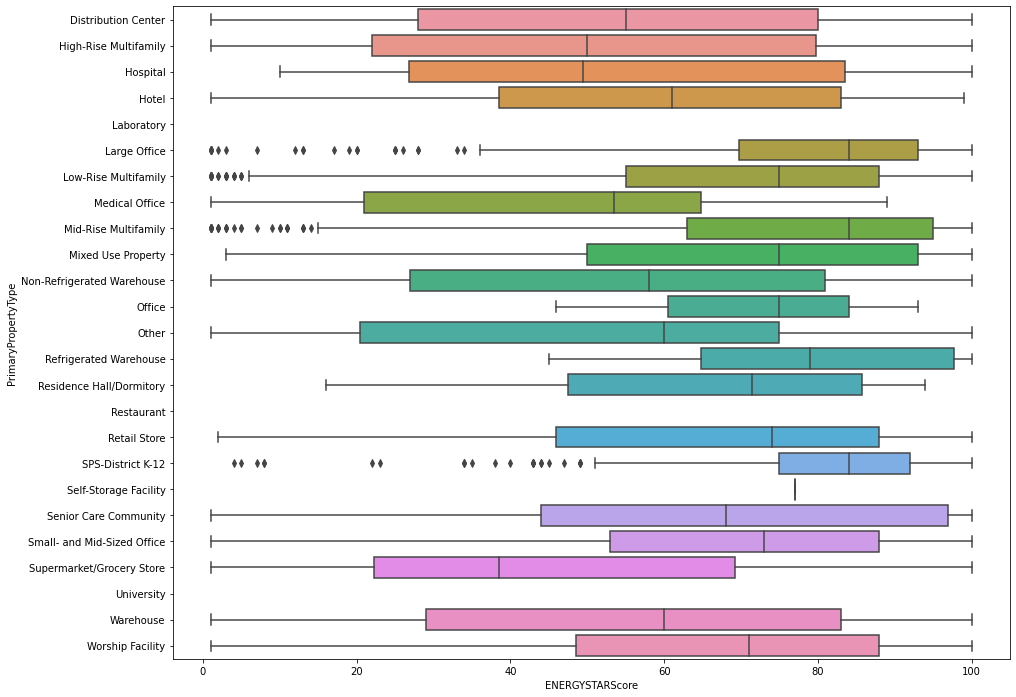

In [51]:
plt.figure(figsize=(15,12))
azerty = df[['ENERGYSTARScore', 'PrimaryPropertyType']].sort_values(by='PrimaryPropertyType')
sns.boxplot(y='PrimaryPropertyType', x='ENERGYSTARScore', data=azerty, orient='h')

In [52]:
df['BuildingAge']=df['DataYear']-df['YearBuilt']
df.drop(columns=['YearBuilt'],inplace=True)

<AxesSubplot:>

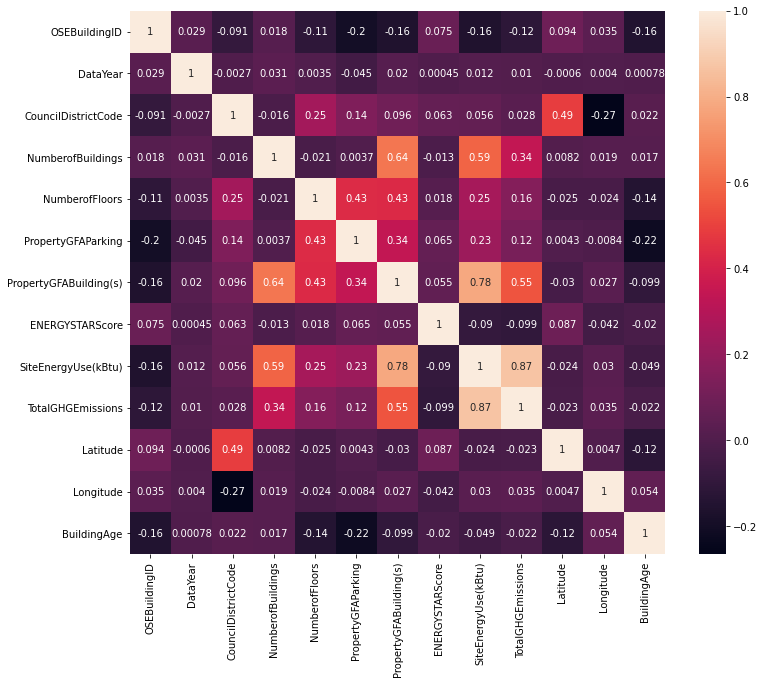

In [53]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True)

In [54]:
locationlist=[]
for index, row in df.iterrows():
    lat = row['Latitude']
    long=row['Longitude']
    locationlist.append([lat, long])

In [55]:
map = folium.Map(location=[df['Latitude'].median(), df['Longitude'].median()], zoom_start=12)
for point in range(0, len(df)):
    folium.CircleMarker(locationlist[point],radius=5).add_to(map)
map

In [56]:
a = df[['CouncilDistrictCode', 'Neighborhood']].groupby('CouncilDistrictCode')['Neighborhood'].apply(list)

In [57]:
def count_(list_code):
    dict_count={}
    items = set(list_code)
    for item in items :
        dict_count[item]=list_code.count(item)
    return dict_count
for i in range (1,8):
    print(count_(a[i]))

{'DELRIDGE': 170, 'GREATER DUWAMISH': 61, 'SOUTHWEST': 331}
{'GREATER DUWAMISH': 676, 'DOWNTOWN': 161, 'EAST': 2, 'SOUTHEAST': 177}
{'DOWNTOWN': 21, 'NORTHEAST': 14, 'CENTRAL': 265, 'GREATER DUWAMISH': 7, 'SOUTHEAST': 14, 'EAST': 829, 'LAKE UNION': 30}
{'NORTH': 6, 'NORTHWEST': 2, 'LAKE UNION': 199, 'NORTHEAST': 504}
{'NORTH': 369, 'NORTHWEST': 291, 'NORTHEAST': 21}
{'BALLARD': 263, 'NORTHWEST': 154, 'LAKE UNION': 75}
{'EAST': 66, 'LAKE UNION': 196, 'DOWNTOWN': 969, 'MAGNOLIA / QUEEN ANNE': 843}


In [58]:
locationlist_2=[]
locationlist=[]
df_1=df[df['CouncilDistrictCode']==2]
df_2=df[df['CouncilDistrictCode']==3]
locationlist=[]
for index, row in df_1.iterrows():
    lat = row['Latitude']
    long=row['Longitude']
    locationlist.append([lat, long])
for index, row in df_2.iterrows():
    lat = row['Latitude']
    long=row['Longitude']
    locationlist_2.append([lat, long])
map = folium.Map(location=[df_1['Latitude'].median(), df_1['Longitude'].median()], zoom_start=12)
for point in range(0, len(df_1)):
    folium.CircleMarker(locationlist[point],radius=5, color='red').add_to(map)
for point in range(0, len(df_2)):
    folium.CircleMarker(locationlist_2[point],radius=5, color='blue').add_to(map)
map

In [59]:
# il semblerait que la variable CouncilDistrictCode ne soit pas pertinente -> on preferera encoder les quartiers

In [60]:
df.drop(columns=['CouncilDistrictCode'], inplace=True)

In [61]:
df['BuildingType'].unique()

array(['NonResidential', 'Multifamily MR (5-9)', 'SPS-District K-12',
       'Multifamily LR (1-4)', 'Campus', 'Multifamily HR (10+)'],
      dtype=object)

In [62]:
numeric_columns= list(df.select_dtypes('float').columns) +list(df.select_dtypes('int').columns)
numeric_columns

['NumberofBuildings',
 'NumberofFloors',
 'ENERGYSTARScore',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'Latitude',
 'Longitude',
 'OSEBuildingID',
 'DataYear',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'BuildingAge']

In [63]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder


for column in list(df.select_dtypes('O').columns):
    encoder=OneHotEncoder(sparse=False)
    cat_encoded = pd.DataFrame(encoder.fit_transform(df[[column]]))

    cat_encoded.columns = encoder.get_feature_names([column])
    df.reset_index(inplace=True, drop=True)
    df= pd.concat([df, cat_encoded], axis=1)
    df.drop(columns=[column], inplace=True)

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:>

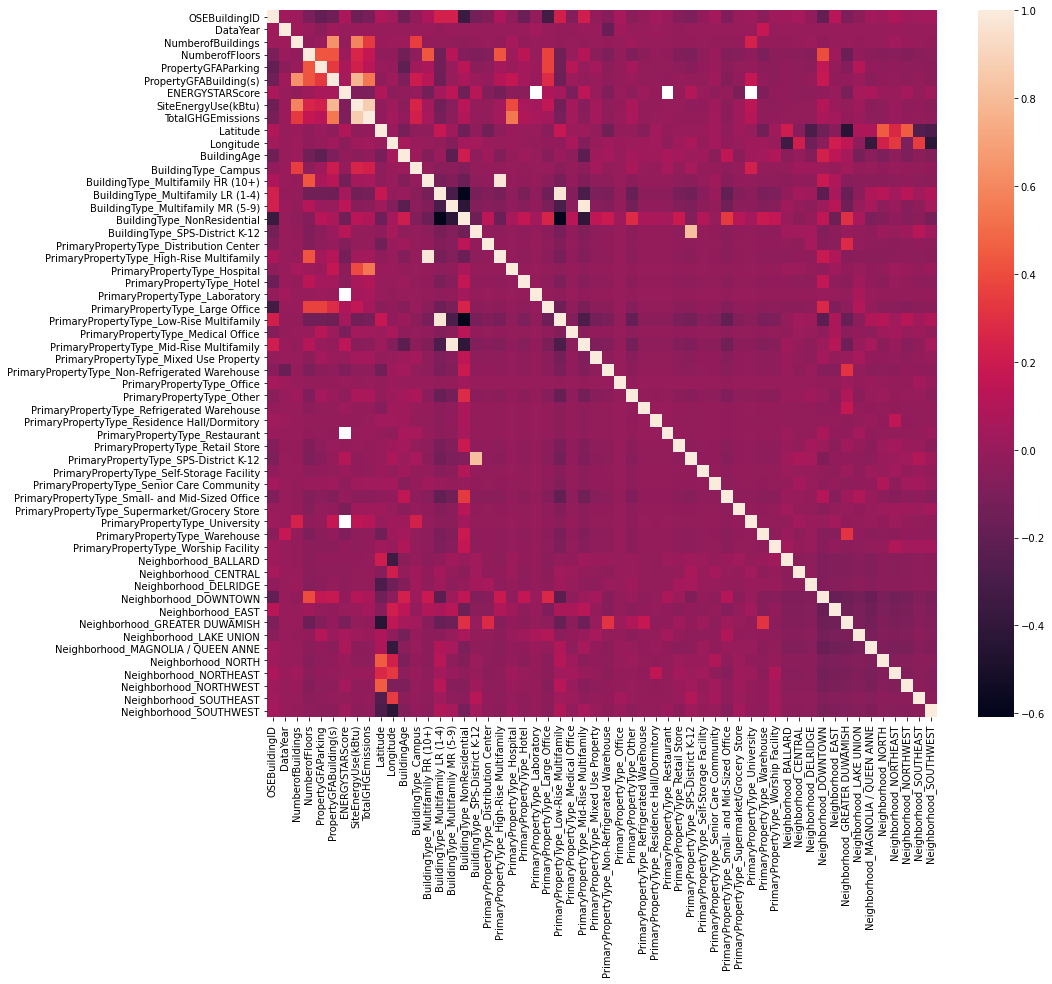

In [64]:
plt.figure(figsize=(15,13))
sns.heatmap(df.corr())

# Normaliser les colonnes

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


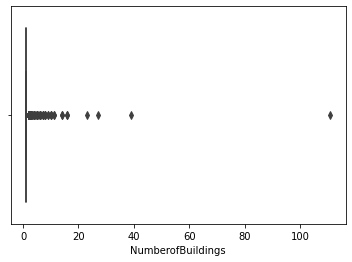

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


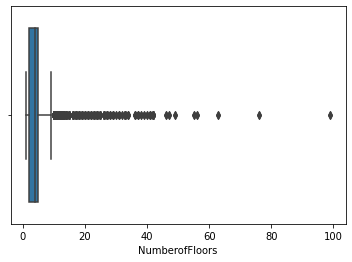

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


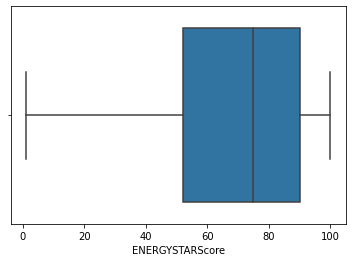

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


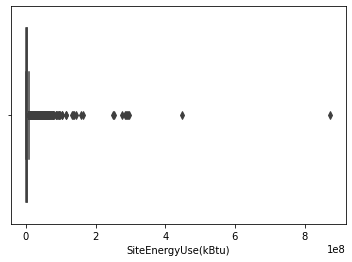

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


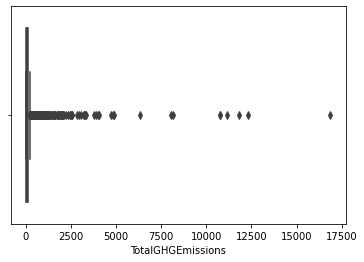

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


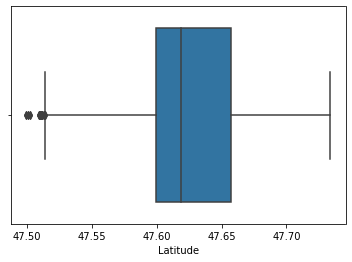

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


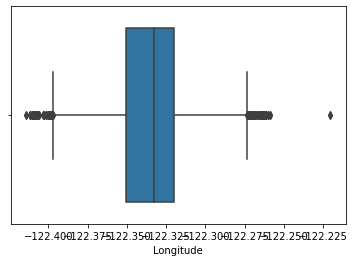

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


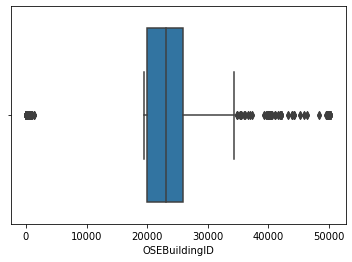

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


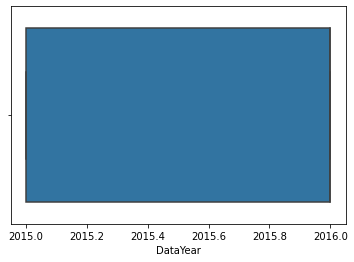

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


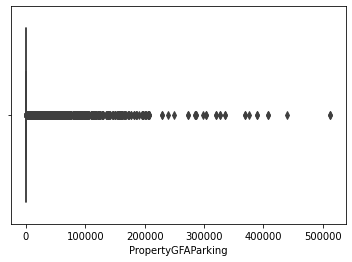

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


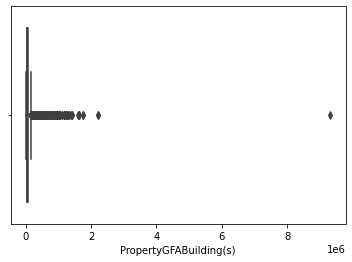

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


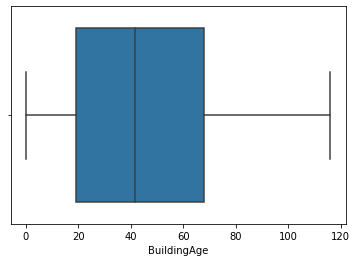

In [66]:
for column in numeric_columns :
    sns.boxplot(df[column])
    plt.show()

In [67]:
#je vais voir si j'enleve les données ou site energie use et total emission sont très élévées, j'obtiens de meilleures graphiques
'''q = df_['SiteEnergyUse(kBtu)'].quantile(0.99)
q
df_ = df_[df_['SiteEnergyUse(kBtu)']<q]'''

"q = df_['SiteEnergyUse(kBtu)'].quantile(0.99)\nq\ndf_ = df_[df_['SiteEnergyUse(kBtu)']<q]"

On peut voir pas mal d'outliers -> Robustscaler \
Pour les targets -> on veut normaliser la distrbution : boxcot ou log

In [68]:
to_robust = [
    'NumberofBuildings',
    'NumberofFloors',
    'ENERGYSTARScore',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'BuildingAge'
            ]
to_drop = ['Latitude',
             'Longitude',
          'OSEBuildingID',
          'DataYear']
targets=['SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',]

In [69]:

for column in to_robust:
    transformer = RobustScaler(unit_variance=True).fit(df[[column]])
    df[column] = transformer.transform(df[[column]])

In [70]:
df['NumberofBuildings'].value_counts()

0.000000      6596
1.348980        42
2.697959        25
4.046939        13
5.395918        10
6.744898         8
8.093877         4
9.442857         3
12.140816        3
17.536734        2
10.791836        2
20.234693        2
13.489795        2
51.261221        1
35.073467        1
29.677549        1
148.387745       1
Name: NumberofBuildings, dtype: int64

In [135]:
df['DataYear'] = df['DataYear'].map({2015:0, 2016:1})

In [136]:
df['DataYear'].unique()

array([0, 1])

# Site energy use prediction

## Dernier ajustements

In [137]:
df_energy = df.copy()

In [138]:
df_energy=df_energy[df_energy['SiteEnergyUse(kBtu)']>0]
df_energy = df_energy[df_energy['SiteEnergyUse(kBtu)']<df_energy['SiteEnergyUse(kBtu)'].max()]
df_energy=df_energy.drop(columns=['Latitude', 'Longitude', 'OSEBuildingID'])

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Lambda value used for Transformation: -0.14454563156427797


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


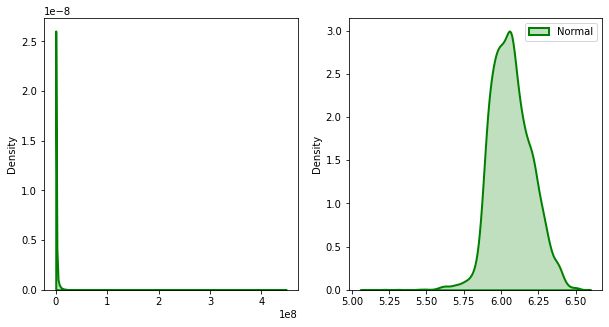

In [139]:
# Python3 code to show Box-cox Transformation
# of non-normal data

# transform training data & save lambda value
fitted_data, fitted_lambda = stats.boxcox(df_energy['SiteEnergyUse(kBtu)'])

# creating axes to draw plots
fig, ax = plt.subplots(1, 2)

# plotting the original data(non-normal) and
# fitted data (normal)
sns.distplot(df_energy, hist = False, kde = True,
kde_kws = {'shade': True, 'linewidth': 2},
             label = "Non-Normal", color ="green", ax = ax[0])

sns.distplot(fitted_data, hist = False, kde = True,
kde_kws = {'shade': True, 'linewidth': 2},
label = "Normal", color ="green", ax = ax[1])

# adding legends to the subplots
plt.legend(loc = "upper right")

# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

print(f"Lambda value used for Transformation: {fitted_lambda}")


In [140]:
# drop energystar score for my primary approch
df_energy = df_energy.drop(columns=['ENERGYSTARScore'])

## prepare X and y

In [141]:
X = df_energy.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions'])
y = df_energy['SiteEnergyUse(kBtu)']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Baseline

In [142]:
dummy_regr_mean = DummyRegressor(strategy="mean")
dummy_regr_median = DummyRegressor(strategy="median")

dummy_regr_mean.fit(X_train, y_train)
dummy_regr_median.fit(X_train, y_train)

y_predict_dummy_mean = dummy_regr_mean.predict(X_test)
y_predict_dummy_median = dummy_regr_median.predict(X_test)

In [143]:
print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, 
                                                                     y_predict_dummy_mean)))

  
print("Median absolute error (dummy): {:.2f}".format(median_absolute_error(y_test, 
                                                                    y_predict_dummy_median)))
  
print("r2_score (dummy mean): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (dummy median): {:.2f}".format(r2_score(y_test, y_predict_dummy_median)))


Mean squared error (dummy): 152632840314957.03
Median absolute error (dummy): 1101032.00
r2_score (dummy mean): -0.00
r2_score (dummy median): -0.06


## First models

In [124]:
from sklearn import metrics
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [147]:
#cv scoring
scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']

### Linear regression

In [158]:
model = 'linear regression'
from sklearn.linear_model import LinearRegression

res = cross_validate(rf, X, y, cv = 5, scoring=scoring)

lr_scores = {
    'time': round(res['fit_time'].mean(),2), 
    'MAE' : round(res['test_neg_mean_absolute_error'].mean(), 2), 
    'RMSE' : round(res['test_neg_root_mean_squared_error'].mean(),2),
    'r2': round(res['test_r2'].mean(),2)
}

print(f"score {model} : {lr_scores['time']}")
print(f"MAE {model} : {lr_scores['MAE']}")
print(f"RMSE {model} : {lr_scores['RMSE']}")
print(f"r2 {model} : {lr_scores['r2']}")

score linear regression : 1.93
MAE linear regression : -1379196.87
RMSE linear regression : -5255364.89
r2 linear regression : 0.82


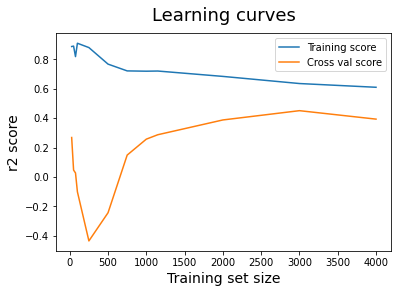

In [167]:
import numpy as np
from sklearn.model_selection import learning_curve

train_sizes = [25,50,75,100,250,500,750,1000,1150, 2000, 3000, 4000]

# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores= learning_curve(estimator=LinearRegression(), X=X, y=y, train_sizes=train_sizes, cv=5)
# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Cross val score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

In [169]:
# Le modele n'a pas l'air d'overfitter mais je vais essayer un lasso /Ridge 
#pour voir si je peux augmenter les performances

### Ridge

In [173]:
from sklearn.linear_model import Ridge
model = Ridge()
grid = {'alpha': np.linspace(-1, 10, 30)}
search = GridSearchCV(model, grid,
                           scoring = 'neg_mean_absolute_error', n_jobs=-1)

# Fit data to Grid Search
search.fit(X,y)
                      
# Best score
print(search.best_score_)
# Best Params
print(search.best_params_)
# Best estimator
print(search.best_estimator_)



-2881284.607049428
{'alpha': -1.0}
Ridge(alpha=-1.0)


In [176]:
model = Ridge(alpha=-1)
res = cross_validate(model, X, y, cv = 5, scoring=scoring)

ridge_scores = {
    'time': round(res['fit_time'].mean(),2), 
    'MAE' : round(res['test_neg_mean_absolute_error'].mean(), 2), 
    'RMSE' : round(res['test_neg_root_mean_squared_error'].mean(),2),
    'r2': round(res['test_r2'].mean(),2)
}

print(f"score {model} : {ridge_scores['time']}")
print(f"MAE {model} : {ridge_scores['MAE']}")
print(f"RMSE {model} : {ridge_scores['RMSE']}")
print(f"r2 {model} : {ridge_scores['r2']}")

score Ridge(alpha=-1) : 0.06
MAE Ridge(alpha=-1) : -2881284.61
RMSE Ridge(alpha=-1) : -8575058.89
r2 Ridge(alpha=-1) : 0.47


### Lasso

In [177]:
from sklearn.linear_model import Lasso
model = Lasso()
grid = {'alpha': np.linspace(-1, 10, 30)}
search = GridSearchCV(model, grid,
                           scoring = 'neg_mean_absolute_error', n_jobs=-1)

# Fit data to Grid Search
search.fit(X,y)
                      
# Best score
print(search.best_score_)
# Best Params
print(search.best_params_)
# Best estimator
print(search.best_estimator_)



-2883825.768868179
{'alpha': 10.0}
Lasso(alpha=10.0)


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.707e+16, tolerance: 1.449e+14
  model = cd_fast.enet_coordinate_descent(


In [181]:
model = Lasso(alpha=10)
res = cross_validate(model, X, y, cv = 5, scoring=scoring)

lasso_scores = {
    'time': round(res['fit_time'].mean(),2), 
    'MAE' : round(res['test_neg_mean_absolute_error'].mean(), 2), 
    'RMSE' : round(res['test_neg_root_mean_squared_error'].mean(),2),
    'r2': round(res['test_r2'].mean(),2)
}

print(f"score {model} : {lasso_scores['time']}")
print(f"MAE {model} : {lasso_scores['MAE']}")
print(f"RMSE {model} : {lasso_scores['RMSE']}")
print(f"r2 {model} : {lasso_scores['r2']}")

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.030e+17, tolerance: 9.273e+13
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.552e+16, tolerance: 1.388e+14
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

score Lasso(alpha=10) : 0.24
MAE Lasso(alpha=10) : -2883825.77
RMSE Lasso(alpha=10) : -8536198.39
r2 Lasso(alpha=10) : 0.48


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.074e+16, tolerance: 1.373e+14
  model = cd_fast.enet_coordinate_descent(


### SVR

In [ ]:
from sklearn.svm import SVR

model = SVR()
grid = {'kernel': ['linear', 'rbf', 'poly'], 'C': np.arange(1, 10)}
search = GridSearchCV(model, grid,
                           scoring = 'neg_mean_absolute_error', n_jobs=-1, verbose=1)

# Fit data to Grid Search
Gridsearching=True
if gridsearching :
    search.fit(X,y)

    # Best score
    print(search.best_score_)
    # Best Params
    print(search.best_params_)
    # Best estimator
    print(search.best_estimator_)

In [ ]:
model = SVR(kernel=,
           C=)
res = cross_validate(model, X, y, cv = 5, scoring=scoring)

svr_scores = {
    'time': round(res['fit_time'].mean(),2), 
    'MAE' : round(res['test_neg_mean_absolute_error'].mean(), 2), 
    'RMSE' : round(res['test_neg_root_mean_squared_error'].mean(),2),
    'r2': round(res['test_r2'].mean(),2)
}

print(f"score {model} : {svr_scores['time']}")
print(f"MAE {model} : {svr_scores['MAE']}")
print(f"RMSE {model} : {svr_scores['RMSE']}")
print(f"r2 {model} : {svr_scores['r2']}")

### KNN

In [190]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
grid = {'n_neighbors': np.arange(5,30)}
search = GridSearchCV(model, grid,
                           scoring = 'neg_mean_absolute_error', n_jobs=-1)

# Fit data to Grid Search
search.fit(X,y)
                      
# Best score
print(search.best_score_)
# Best Params
print(search.best_params_)
# Best estimator
print(search.best_estimator_)


-2851023.898329499
{'n_neighbors': 5}
KNeighborsRegressor()


In [192]:
model = KNeighborsRegressor(n_neighbors=5)
res = cross_validate(model, X, y, cv = 5, scoring=scoring)

knn_scores = {
    'time': round(res['fit_time'].mean(),2), 
    'MAE' : round(res['test_neg_mean_absolute_error'].mean(), 2), 
    'RMSE' : round(res['test_neg_root_mean_squared_error'].mean(),2),
    'r2': round(res['test_r2'].mean(),2)
}

print(f"score {model} : {knn_scores['time']}")
print(f"MAE {model} : {knn_scores['MAE']}")
print(f"RMSE {model} : {knn_scores['RMSE']}")
print(f"r2 {model} : {knn_scores['r2']}")

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


score KNeighborsRegressor() : 0.0
MAE KNeighborsRegressor() : -2851023.9
RMSE KNeighborsRegressor() : -9570474.97
r2 KNeighborsRegressor() : 0.39


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


### Random Forest

In [195]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
grid = {'n_estimators': np.arange(10,200, 10), 
        'min_samples_split':np.arange(2,10),
       'min_samples_leaf':np.arange(1,10)}
search = GridSearchCV(model, grid,
                           scoring = 'neg_mean_absolute_error', n_jobs=-1, verbose=1)
Gridsearching=False
# Fit data to Grid Search
if Gridsearching :
    search.fit(X,y)        
    # Best score
    print(search.best_score_)
    # Best Params
    print(search.best_params_)
    # Best estimator
    print(search.best_estimator_)

-1368772.203441407
{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 140}
RandomForestRegressor(n_estimators=140)


In [200]:
model = RandomForestRegressor(
    n_estimators= 140,
    min_samples_split=2,
    min_samples_leaf=1)
res = cross_validate(model, X, y, cv = 5, scoring=scoring)

randomforest_scores = {
    'time': round(res['fit_time'].mean(),2), 
    'MAE' : round(res['test_neg_mean_absolute_error'].mean(), 2), 
    'RMSE' : round(res['test_neg_root_mean_squared_error'].mean(),2),
    'r2': round(res['test_r2'].mean(),2)
}

print(f"score {model} : {randomforest_scores['time']}")
print(f"MAE {model} : {randomforest_scores['MAE']}")
print(f"RMSE {model} : {randomforest_scores['RMSE']}")
print(f"r2 {model} : {randomforest_scores['r2']}")

score RandomForestRegressor(n_estimators=140) : 2.7
MAE RandomForestRegressor(n_estimators=140) : -1397602.27
RMSE RandomForestRegressor(n_estimators=140) : -5410624.67
r2 RandomForestRegressor(n_estimators=140) : 0.81


### XGBOOST

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
grid = {'n_estimators': np.arange(10,200, 20), 
        'min_samples_split':np.arange(2,10),
       'min_samples_leaf':np.arange(1,10)}
search = GridSearchCV(model, grid,
                           scoring = 'neg_mean_absolute_error', n_jobs=-1, verbose=1)
Gridsearching=True
# Fit data to Grid Search
if Gridsearching :
    search.fit(X,y)        
    # Best score
    print(search.best_score_)
    # Best Params
    print(search.best_params_)
    # Best estimator
    print(search.best_estimator_)

In [ ]:
model = GradientBoostingRegressor(
    'n_estimators': ,
    'min_samples_split':,
    'min_samples_leaf':)
res = cross_validate(model, X, y, cv = 5, scoring=scoring)

XGBOST_scores = {
    'time': round(res['fit_time'].mean(),2), 
    'MAE' : round(res['test_neg_mean_absolute_error'].mean(), 2), 
    'RMSE' : round(res['test_neg_root_mean_squared_error'].mean(),2),
    'r2': round(res['test_r2'].mean(),2)
}

print(f"score {model} : {XGBOST_scores['time']}")
print(f"MAE {model} : {XGBOST_scores['MAE']}")
print(f"RMSE {model} : {XGBOST_scores['RMSE']}")
print(f"r2 {model} : {XGBOST_scores['r2']}")

In [196]:
# Bagging -> pas assez de features à mon avis

In [ ]:
#Comparaison :
plt.bar()

In [122]:
df['SiteEnergyUse(kBtu)'].mean()

5194673.270239048

In [ ]:
df_energy.columns

In [ ]:
df_['TotalGHGEmissions'].min()

In [ ]:
# Python3 code to show Box-cox Transformation
# of non-normal data

# transform training data & save lambda value
fitted_data, fitted_lambda = stats.boxcox(df_['TotalGHGEmissions'])

# creating axes to draw plots
fig, ax = plt.subplots(1, 2)

# plotting the original data(non-normal) and
# fitted data (normal)
sns.distplot(df_, hist = False, kde = True,
kde_kws = {'shade': True, 'linewidth': 2},
             label = "Non-Normal", color ="green", ax = ax[0])

sns.distplot(fitted_data, hist = False, kde = True,
kde_kws = {'shade': True, 'linewidth': 2},
label = "Normal", color ="green", ax = ax[1])

# adding legends to the subplots
plt.legend(loc = "upper right")

# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

print(f"Lambda value used for Transformation: {fitted_lambda}")


In [ ]:
'''from sklearn.feature_selection import SelectFromModel
select = SelectFromModel(rfc, prefit=True, threshold=0.003)
X_train2 = select.transform(X'''

In [ ]:
list(df.select_dtypes('O').columns)